**This implementation is based of https://people.duke.edu/~charvey/Teaching/BA453_2006/Idzorek_onBL.pdf**

In [163]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

In [164]:
tickers = ["AAPL","MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"] #name our portfolio
prices = yf.download(tickers, start="2018-01-01", end="2024-03-01")['Adj Close'] #give date
prices.tail()
market_prices = yf.download("SPY", period="max")["Adj Close"] #baseline We might change this depending on the tickers
market_prices.head()
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
#caps

[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed


**We have now loaded our data**



<Axes: xlabel='Ticker', ylabel='Ticker'>

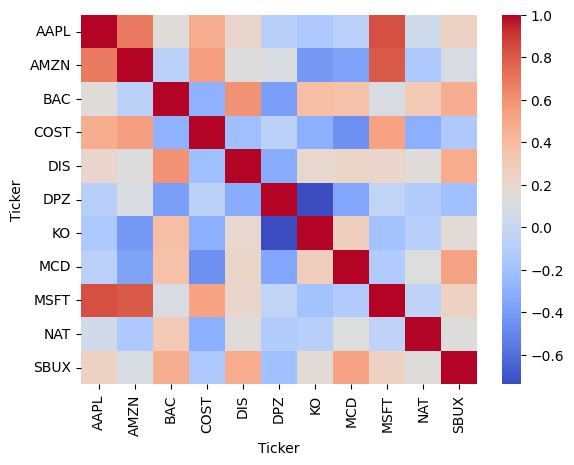

In [165]:
import pypfopt
pypfopt.__version__
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta
#Visualize the Covariant Correlation
sns.heatmap(S.corr(), cmap='coolwarm')

**We now retrieve the correlation matrix**

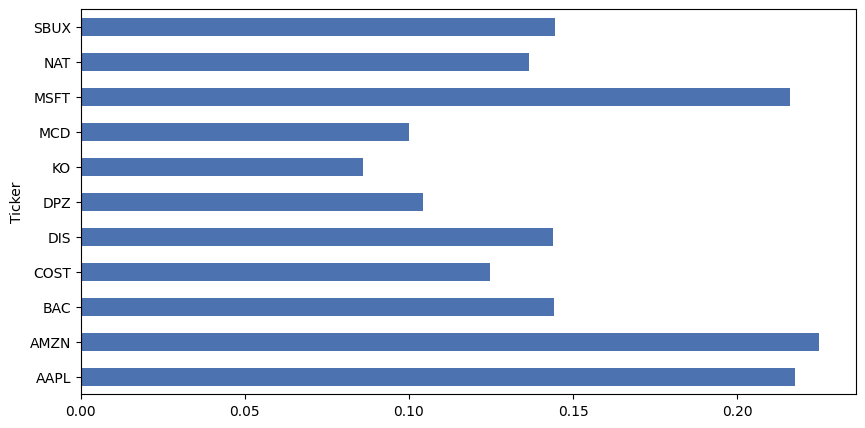

In [166]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior
market_prior.plot.barh(figsize=(10,5));

**implied returns have been established**

**Now we need to input our predictions and confidence levels for ESG and Value.**

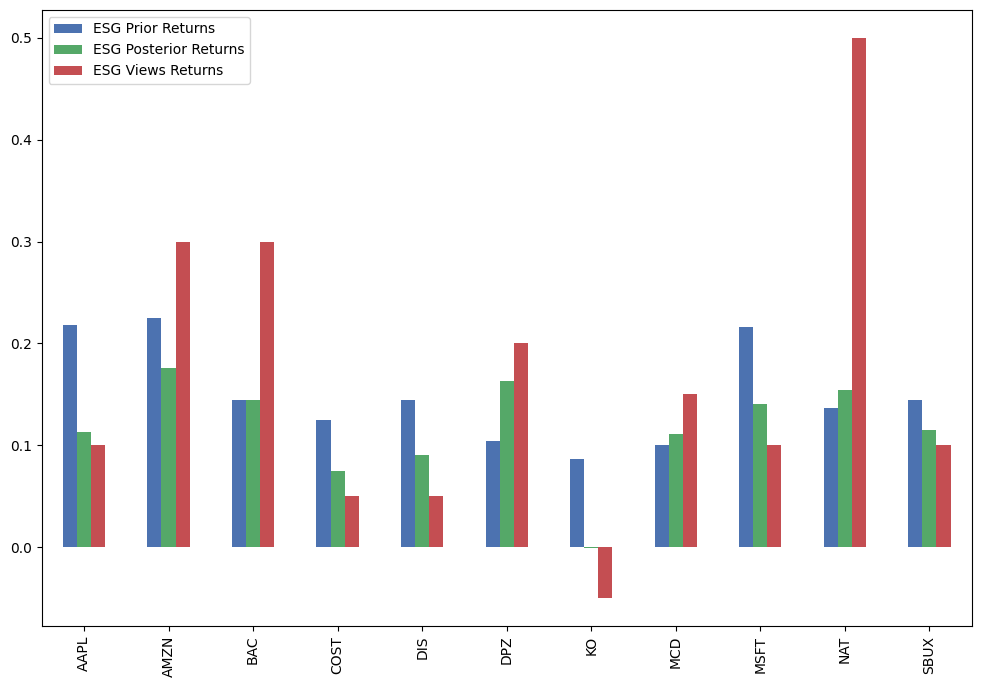

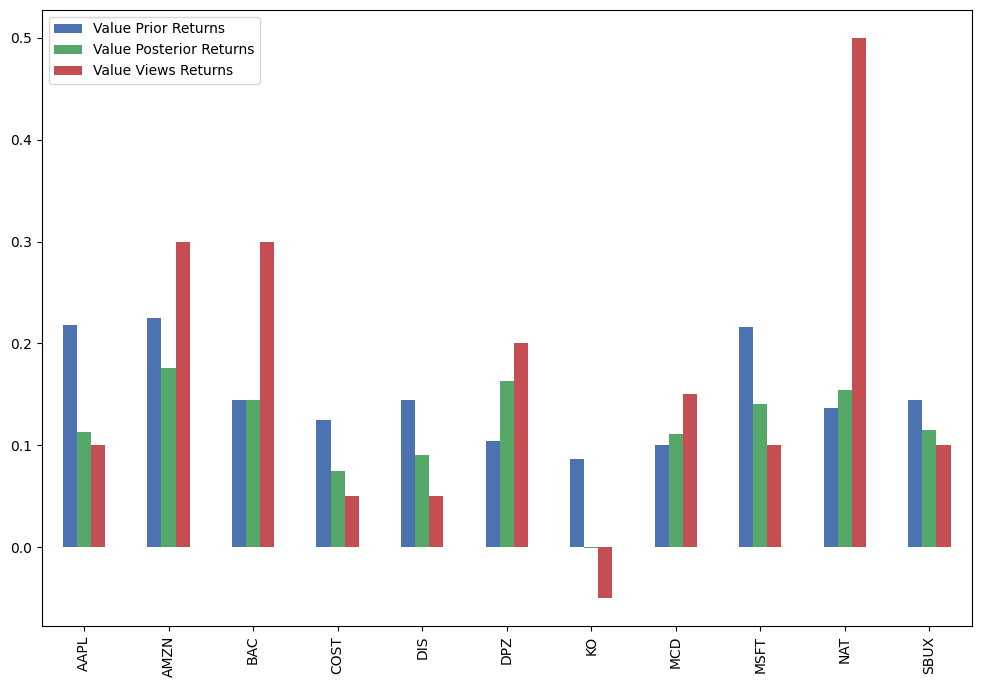

In [167]:
ESG_viewdict = {
    "AAPL": 0.10,
    "AMZN": 0.30,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}
Value_viewdict = {
    "AAPL": 0.10,
    "AMZN": 0.30,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

ESG_confidences = [
    0.9,
    0.2,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7,
    0.5,
    0.1,
    0.4
]
Value_confidences = [
    0.9,
    0.2,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7,
    0.5,
    0.1,
    0.4
]
def BL_Plot(viewdict, confidences,title):
  bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)
  # Posterior estimate of returns
  ret_bl = bl.bl_returns()
  ret_bl
  rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
              index=[f"{title} Prior Returns", f"{title} Posterior Returns", f"{title} Views Returns"]).T
  rets_df
  rets_df.plot.bar(figsize=(12,8));

BL_Plot(ESG_viewdict, ESG_confidences,title="ESG")
BL_Plot(Value_viewdict, Value_confidences,title="Value")


**We now combine our views.**

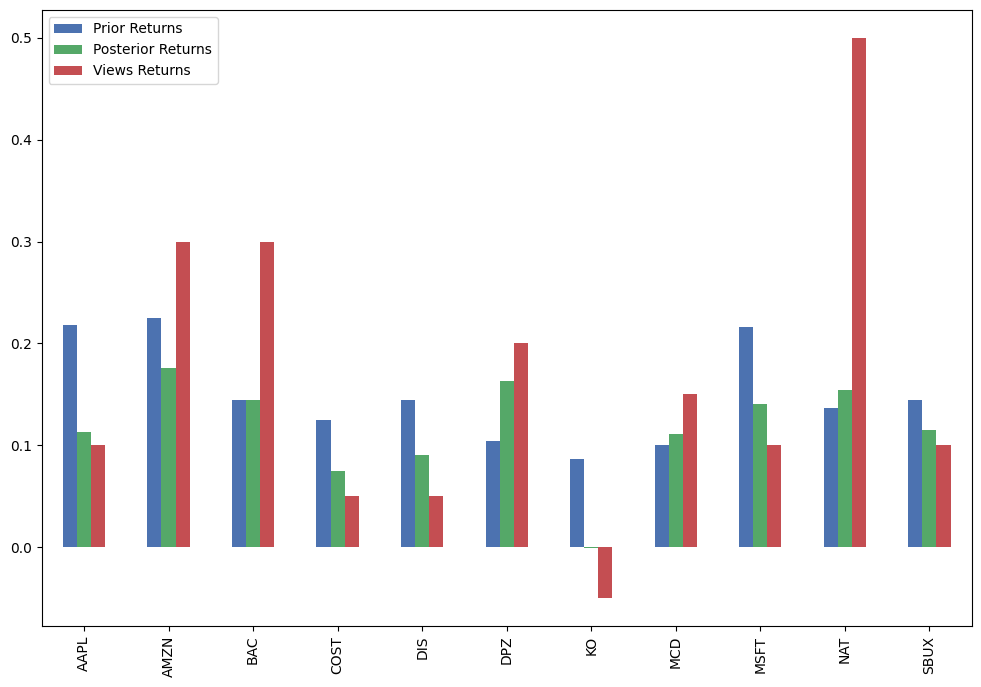

In [171]:
confidences= [(esg + value) / 2 for esg, value in zip(ESG_confidences, Value_confidences)] #average our confidences
viewdict = {key: (ESG_viewdict[key] + Value_viewdict[key]) / 2 for key in ESG_viewdict} #average the two views


bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior Returns", "Posterior Returns", "Views Returns"]).T
rets_df
rets_df.plot.bar(figsize=(12,8));

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Text(0.5, 1.0, 'Portfolio Weights')

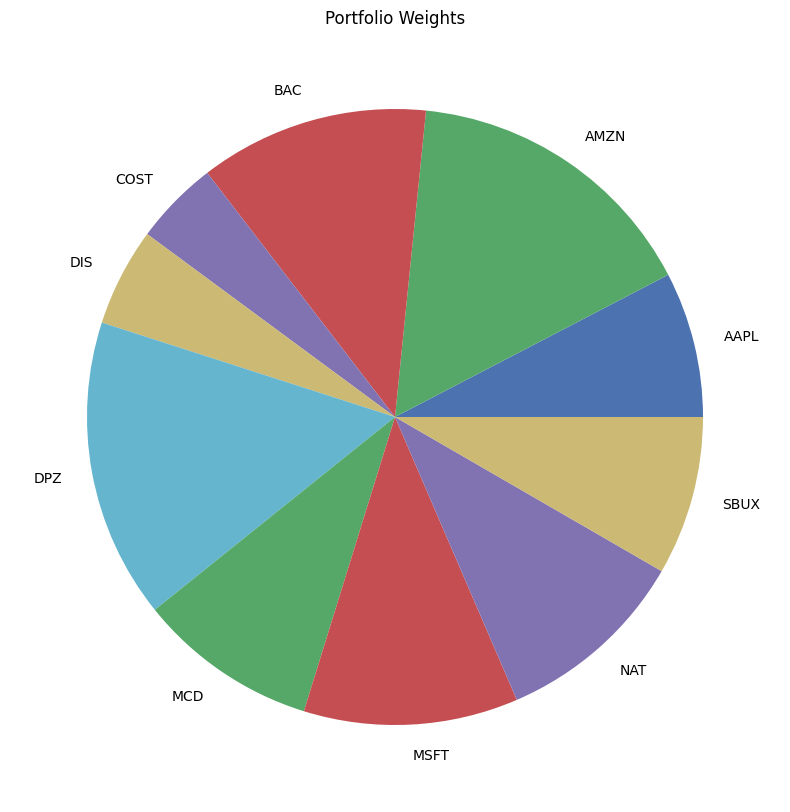

In [172]:
from pypfopt import EfficientFrontier, objective_functions
S_bl = bl.bl_cov()
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights
pd.Series(weights).plot.pie(figsize=(10,10));
plt.title('Portfolio Weights')

Expected annual return: 13.9%
Annual volatility: 22.5%
Sharpe Ratio: 0.53


/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.1388508876663806, 0.22477748425747704, 0.5287490784897292)

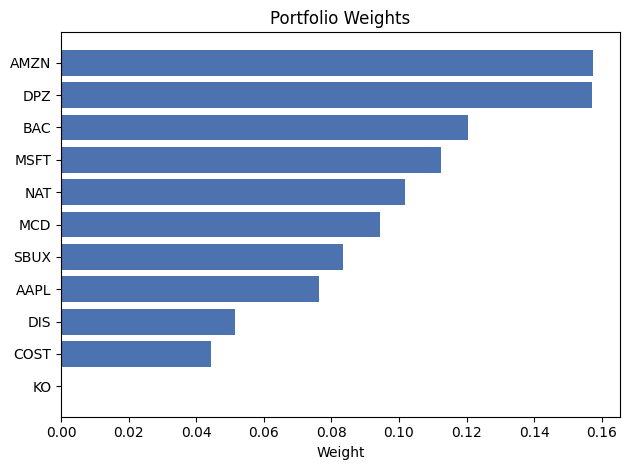

In [173]:
from pypfopt.plotting import plot_weights
plt.title('Portfolio Weights')
plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)